In [ ]:
import os
import torch
from pathlib import Path
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.ao.quantization as tq
from torchvision.utils import make_grid

import re

import matplotlib.pyplot as plt
%matplotlib inline

from ubervvald.DNAS import prepare_NAS, NAS_finetune, export_NAS, NAS_train, NASConfig
from ubervvald import set_seed
from ubervvald.quant import quantize, prepare_quantize

import warnings
# warnings.filterwarnings('ignore')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
set_seed()

c:\Users\uie64426\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'dataset/dresses'
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))

['white_dress', 'white_shorts', 'brown_pants', 'black_shorts', 'green_shirt', 'black_dress', 'green_shoes', 'green_pants', 'brown_shorts', 'blue_shorts', 'blue_pants', 'red_pants', 'black_shirt', 'blue_dress', 'white_shoes', 'black_shoes', 'white_pants', 'blue_shoes', 'red_shoes', 'black_pants', 'blue_shirt', 'red_dress', 'green_shorts', 'brown_shoes']
24


In [3]:
#Making a list that contains the paths of each image
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(data_dir):  
    for name in files:
      #print(os.path.join(path, name)) 
      images.append(os.path.join(path, name))
  return images

In [4]:
#creating a list of classes
classes = ['black', 'blue', 'brown', 'green', 'white', 'red', 'dress', 'pants', 'shorts', 'shoes', 'shirt']
len(classes)

11

In [5]:
def encode_label(label, classes_list = classes): #encoding the classes into a tensor of shape (11) with 0 and 1s.
    target = torch.zeros(11)
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target


def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])     
    return ' '.join(result)

In [6]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              
        self.labels = [encode_label(re.findall(r'\w+\_\w+', img_path)[0].split('_')) for img_path in self.images]
        self.npLabels = [label.numpy(force=True) for label in self.labels]
        self.ptLabels = torch.stack([torch.Tensor(label) for label in self.npLabels])

    def __len__(self):
        return len(self.images)       

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
       
        if self.transform:
            img = self.transform(img)    
            
        # label = re.findall(r'\w+\_\w+', img_path)[0].split('_') 
        
        return img, self.labels[idx]#encode_label(label)   


In [7]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images 
transform= T.Compose([T.Resize(128),
                      T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [8]:
#Creating a dataset that loads images from the specified directory, encode their labels and transforming them into tensors.
dataset = myDataset(data_dir, transform = transform)
len(dataset)

11385

In [9]:
dataset[1]

(tensor([[[-2.1179,  0.0056, -0.0116,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179,  0.0056, -0.0116,  ...,  0.0398,  0.0398,  0.0227],
          [-2.1179,  0.0056, -0.0116,  ...,  0.0569,  0.0569,  0.0398],
          ...,
          [ 0.5878,  0.6049,  0.6221,  ...,  0.4508,  0.4679, -2.1179],
          [ 0.5878,  0.6049,  0.6221,  ...,  0.4508,  0.4679, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ...,  0.4508,  0.4679, -2.1179]],
 
         [[-2.0357,  0.1352,  0.1176,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357,  0.1352,  0.1176,  ...,  0.1702,  0.1702,  0.1527],
          [-2.0357,  0.1352,  0.1176,  ...,  0.1877,  0.1877,  0.1702],
          ...,
          [ 0.7304,  0.7479,  0.7654,  ...,  0.5903,  0.6078, -2.0357],
          [ 0.7304,  0.7479,  0.7654,  ...,  0.5903,  0.6078, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ...,  0.5903,  0.6078, -2.0357]],
 
         [[-1.8044,  0.3568,  0.3393,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,  0.3568,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


Label: brown shoes

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])


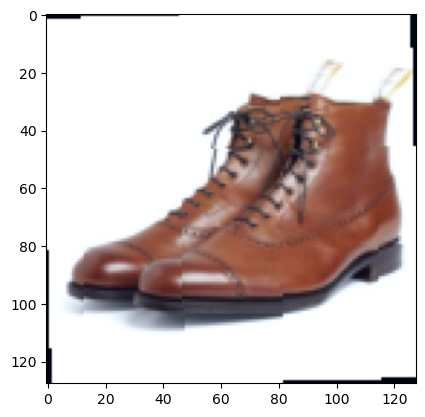

In [10]:
def denorm(img_tensors): #this function will denormalize the tensors 
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*dataset[11380]) #let's take an example

In [11]:
test_percent = int(0.30 * len(dataset)) #setting 20 percent of the total number of images for test
train_size = len(dataset) - test_percent
test_size = len(dataset) - train_size
ref_test_size = test_size
val_percent = int(0.60 * ref_test_size) #setting 10 percent of the total number of images for validation
test_size = ref_test_size - val_percent
val_size = ref_test_size - test_size
train_size, val_size, test_size

(7970, 2049, 1366)

In [12]:
train_ds, test_val_ds = random_split(dataset, [train_size, ref_test_size]) #splitting the dataset for training and validation.
test_ds, val_ds = random_split(test_val_ds, [test_size, val_size]) #splitting the dataset for training and validation.
len(train_ds), len(val_ds), len(test_ds)

(7970, 2049, 1366)

In [13]:
#setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

In [14]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32, 11])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


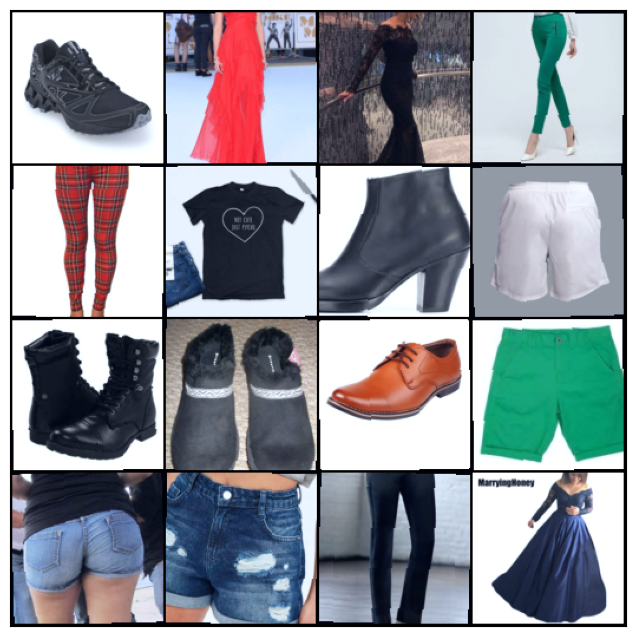

In [15]:
#let's see a batch of images (16 images) in a grid
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(nn.Module):
    def __init__(self, in_channels, num_classes, fuse=None):
        self.fuse_nodes = fuse if type(fuse) is list else None
        super().__init__()     
        #input 3 x 128 x 128
        self.quant = tq.QuantStub()
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2


        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 11     
        # self.output = nn.Sigmoid()
        self.dequant = tq.DeQuantStub()
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        # out = F.sigmoid(out)
        # out = self.output(out)
        out = self.dequant(out)
        return out        

    def set_qconfig(self, qconfig):
        self.qconfig = qconfig

    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self, is_qat=False):
        fuse_modules = torch.ao.quantization.fuse_modules_qat if is_qat else torch.ao.quantization.fuse_modules
        for m in self.modules():
            if type(m) == nn.Sequential:
                layer_list = ['0', '1', '2']
                if [True for name, _ in m.named_children() if name.find("conv") != -1][0]:
                    layer_list.append('3')
                fuse_modules(m, layer_list, inplace=True)

In [17]:
model = ResNet15(3, len(classes))#input channel: 3, output size: 11, loading model onto GPU
model

ResNet15(
  (quant): QuantStub()
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, d

In [18]:
#checking the shape of outputs that the model will produce before starting the training process
# for images, labels in train_dl:
#     print(images.shape)
#     outputs = F.sigmoid(model(images))
#     break

# print('outputs.shape : ', outputs.shape)
# print('Sample outputs :\n', outputs[:2].data)

In [19]:
class_frequencies = torch.count_nonzero(train_ds.dataset.ptLabels, dim=0)
loss_weights = torch.sum(class_frequencies) / (class_frequencies)
loss_weights, class_frequencies

(tensor([ 7.2748,  7.9532, 27.9387, 21.7479, 12.5662, 13.2538,  8.8599,  8.1642,
         24.6963,  6.6618, 13.5053]),
 tensor([3130, 2863,  815, 1047, 1812, 1718, 2570, 2789,  922, 3418, 1686]))

In [ ]:
 # DATASET_DIR = Path("dataset/dataset")
# model_dir = Path(f"nas_model/")
# REG_STRENGTHS = [0.000001]
# epochs = 3
# max_lr = 0.001
# grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

@NASConfig
def crit(train_ds):
    # compute the number of windows belonging to each class
    if "dataset" in dir(train_ds.dataset):
        train_ds = train_ds.dataset
    # classes, class_frequencies = np.unique(train_ds.dataset.npLabels, return_counts=True)
    class_frequencies = torch.count_nonzero(train_ds.dataset.ptLabels, dim=0)
    # derive corresponding loss weights as w_class_i = tot_windows / class_i_windows
    loss_weights = torch.sum(class_frequencies) / (class_frequencies)
    
    # create an instance of the torch.nn.CrossEntropyLoss with weight and label_smoothing and return it 
    crit = torch.nn.BCELoss(weight=loss_weights.to(NASConfig.get_device()))
    return crit

@NASConfig
def optimizer(model):
    # Set up custom optimizer with weight decay
    optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
    # Set up one-cycle learning rate scheduler
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    return optim

@NASConfig
def nas_opt(model):
    # config = get_NASConfig()
    net_optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
    nas_optim = opt_func(model.parameters(), lr=NASConfig.get_nas_lr())
    return net_optim, nas_optim

TRAINING_CONFIG = {
    'model_dir': Path("experiments/nas_model/"),
    'epochs': 150,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'nas_learning_rate': 0.001,
    'num_classes': len(classes),
    'label_smoothing': 0.25,
    'weight_decay':weight_decay,
    'patience': 30,
    'reg_strengths': [1e-6, 0],#0 meaning to take the reg strength from the index 0 if it is not intended to have it selected by the user
    'criterion': crit,
    "last_layer_activation": F.sigmoid,
    'optimizer': optimizer,
    # 'qat_qconfig': tq.get_default_qat_qconfig(backend='x86', version=1),
    'nas_optimizer':nas_opt,
    'isMultilabel' : True,
    'isGPU': True,
    'lambda': False
}

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [21]:
prepare_NAS(TRAINING_CONFIG)
model = NAS_train(model, train_ds, val_ds, test_ds)
# model = export_NAS(model, train_ds, val_ds, test_ds)

/home/hil/efcl/qNAS/qNAS/_utils.py:289: UserWarning: lambda notified will be ignored
  [warnings.warn(
/home/hil/efcl/qNAS/qNAS/_utils.py:152: RuntimeWarning: key qat_qconfig is missing from the config. Reverting to overwriteable default 
  warnings.warn(
/home/hil/efcl/qNAS/qNAS/_utils.py:152: RuntimeWarning: key n_work is missing from the config. Reverting to overwriteable default 
  warnings.warn(



Training data-loader length: 249 (nr. of batches)
Validation data-loader length: 65 (nr. of batches)
Test data-loader length: 43 (nr. of batches)
Working on: cuda:0
Val Seed Macro Acc: 0.36323705315589905
Model's initial cost (nr. of param): 30,028,684.0
Training with strength 1e-06
Epoch: 1, Total NAS Loss: 31.61,  Task Loss: 2.67, Acc: 0.39, Macro Acc: 0.91 Val Task Loss: 1.45, Val Acc: 0.64, Val Macro Acc: 0.95,  Model Cost: 30,028,684.0
Epoch: 2, Total NAS Loss: 31.07,  Task Loss: 1.43, Acc: 0.69, Macro Acc: 0.96 Val Task Loss: 0.91, Val Acc: 0.77, Val Macro Acc: 0.97,  Model Cost: 30,028,684.0
Epoch: 3, Total NAS Loss: 31.23,  Task Loss: 1.15, Acc: 0.75, Macro Acc: 0.97 Val Task Loss: 1.10, Val Acc: 0.77, Val Macro Acc: 0.97,  Model Cost: 30,028,684.0
Epoch: 4, Total NAS Loss: 30.98,  Task Loss: 0.95, Acc: 0.80, Macro Acc: 0.97 Val Task Loss: 0.81, Val Acc: 0.82, Val Macro Acc: 0.97,  Model Cost: 30,028,684.0
Epoch: 5, Total NAS Loss: 30.93,  Task Loss: 0.84, Acc: 0.82, Macro Acc

/home/hil/efcl/qNAS/qNAS/_utils.py:697: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_obj = torch.load(checkpoint)


Test Loss: 2.34, Test Acc: 0.61, Test Macro Acc: 0.93

Working on: cuda:0
The following regularization strength has been found:
	1. 1e-06


/home/hil/efcl/qNAS/qNAS/_utils.py:589: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_info = torch.load(os.path.join(checkpoint_dir, 'best.ckp'), map_location='cpu')


Test Macro Acc after re-loading: 0.9295887351036072
Model's cost (nr. of param) after NAS: 29,617.0
Epoch: 1, Loss: 3.08, Acc: 0.37, Macro Acc: 0.90 Val Loss: 1.98, Val Acc: 0.55, Val Macro Acc: 0.93
Epoch: 2, Loss: 2.47, Acc: 0.47, Macro Acc: 0.92 Val Loss: 1.81, Val Acc: 0.59, Val Macro Acc: 0.94
Epoch: 3, Loss: 2.35, Acc: 0.50, Macro Acc: 0.92 Val Loss: 1.77, Val Acc: 0.60, Val Macro Acc: 0.94
Epoch: 4, Loss: 2.25, Acc: 0.51, Macro Acc: 0.93 Val Loss: 1.75, Val Acc: 0.62, Val Macro Acc: 0.94
Epoch: 5, Loss: 2.21, Acc: 0.52, Macro Acc: 0.93 Val Loss: 1.68, Val Acc: 0.61, Val Macro Acc: 0.95
Epoch: 6, Loss: 2.18, Acc: 0.54, Macro Acc: 0.93 Val Loss: 1.66, Val Acc: 0.63, Val Macro Acc: 0.94
Epoch: 7, Loss: 2.12, Acc: 0.54, Macro Acc: 0.93 Val Loss: 1.66, Val Acc: 0.63, Val Macro Acc: 0.94
Epoch: 8, Loss: 2.11, Acc: 0.54, Macro Acc: 0.93 Val Loss: 1.71, Val Acc: 0.63, Val Macro Acc: 0.94
Epoch: 9, Loss: 2.08, Acc: 0.55, Macro Acc: 0.93 Val Loss: 1.62, Val Acc: 0.64, Val Macro Acc: 0.95


In [22]:
# model = torch.load("experiments/nas_model/final_model_1e-06.pt")
import onnxruntime
config = {
    'arch': 'resnet15',
    'quant_format': onnxruntime.quantization.QuantFormat.QOperator,
    'quant_w_type': onnxruntime.quantization.QuantType.QInt8,
    'quant_a_type': onnxruntime.quantization.QuantType.QUInt8,
    'batch_size': 1,
    'model_dir': 'experiments/quant_models/',
    'last_layer_activation': torch.nn.functional.sigmoid,
    'isGPU': False,
}
prepare_quantize(model, config)
quantize(test_ds)

/home/hil/miniconda3/envs/efcl/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/hil/efcl/qNAS/qNAS/_utils.py:152: RuntimeWarning: key q_type is missing from the config. Reverting to overwriteable default 
  warnings.warn(


/home/hil/miniconda3/envs/efcl/lib/python3.10/site-packages/torch/onnx/utils.py:782: UserWarning: no signature found for <torch.ScriptMethod object at 0x7ff1403131f0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
100%|##########| 500/500 [00:06<00:00, 74.16batches/s]


Fscore ref:  tensor(0.8065)
Fscore sample:  tensor(0.8065)




100%|##########| 500/500 [00:39<00:00, 12.74batches/s]

Fscore ref:  tensor(0.8137)
Fscore sample:  tensor(0.8045)




In [ ]:
from ubervvald import get_pit_model
model = torch.load("experiments/nas_model/final_model_1e-06.pt")
print(get_pit_model(model, train_ds[0][0].shape).cost.item())
# export_quantize(model, "resnet15", dataset, last_layer_act=F.sigmoid, batch_size=1)

/tmp/ipykernel_62623/723967786.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("experiments/nas_model/final_model_1e-06.pt")


29617.0


In [2]:
import onnx
from onnx import numpy_helper

model_path = "experiments/quant_models/resnet15_int8.onnx"

def count_parameters(onnx_model_path):
    model = onnx.load(onnx_model_path)
    total_parameters = 0
    for initializer in model.graph.initializer:
        total_parameters += numpy_helper.to_array(initializer).size
    return total_parameters

num_params = count_parameters(model_path)
print("num_of_params: ", num_params)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/quant_models/resnet15_int8.onnx'

Reference links and appreciation notes:

    1) I could have come this far all thanks to the amazing (FREE ONLINE) course (Deep Learning with PyTorch: Zero to GANs) from Jovian.ai which is available at the link here,
    https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans
        
    2) I would also like to say thank you to the creator of this dataset and give credits to his notebook (https://www.kaggle.com/trolukovich/multi-label-classification-keras) that I have taken as reference.   
    